In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
from IPython.display import clear_output

In [2]:
#input dimensions
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
flatten_img_shape = np.prod(img_shape)
z_dim    = 100

In [3]:
#hyperparamters
epochs = 30
gen_lr = 0.001
dis_lr = 0.001
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [4]:
#reshape module
class Reshape(nn.Module):
    def __init__(self, args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [5]:
#generator
generator = nn.Sequential(
    nn.Linear(z_dim, 128),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Linear(128,flatten_img_shape),
    nn.Tanh(),
    Reshape((-1,*img_shape))
).to(device)

In [6]:
#discriminator
discriminator = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(flatten_img_shape, 128),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Linear(128,1),
    nn.Sigmoid()
).to(device)

In [7]:
#gan
gan = nn.Sequential(
    generator,
    discriminator
).to(device)

In [8]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = (image_tensor.reshape(-1, *size) * 0.5) + 0.5
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.show()

In [9]:
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=gen_lr)
dis_optimizer = torch.optim.Adam(discriminator.parameters(),lr=dis_lr)
gen_criterion = torch.nn.BCELoss()
dis_criterion = torch.nn.BCELoss()

In [10]:
def train(gen, dis, gen_optimizer, dis_optimizer, gen_criterion, dis_criterion, batch_size, z_dim, epochs):
    d_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(mean=(0.5,), std =(0.5,))
                               ])),  
    batch_size=batch_size, shuffle=True)
    
    label_fake = torch.zeros((batch_size,1)).to(device)
    label_real = torch.ones((batch_size,1)).to(device)
    avg_gen_loss = []
    avg_dis_loss = []
    for epoch in tqdm(range(epochs)):
        epoch_gen_loss = []
        epoch_dis_loss = []
        for x, _ in tqdm(d_loader):
            real_imgs = x.reshape((-1,*img_shape)).to(device)
            #training discriminator
            #real images
            dis_optimizer.zero_grad()
            real_dis_pred = dis(real_imgs)
            real_dis_loss = dis_criterion(real_dis_pred, label_real)
            real_dis_loss.backward()

            #fake images
            noise = torch.randn((batch_size,z_dim),device = device) #
            with torch.no_grad():
                fake_imgs = gen(noise).to(device).detach()
            
            fake_dis_pred = dis(fake_imgs)
            fake_dis_loss = dis_criterion(fake_dis_pred, label_fake)
            fake_dis_loss.backward()
                
            epoch_dis_loss.append(real_dis_loss.mean().item() + fake_dis_loss.mean().item())
                
            dis_optimizer.step()
            
            #training generator
            noise = torch.randn((batch_size,z_dim),device = device)
            fake_imgs = gen(noise)
            dis_pred = dis(fake_imgs).to(device)
            gen_loss = gen_criterion(dis_pred, label_real) 
            epoch_gen_loss.append(gen_loss.mean().item())
            
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()
            
        mean_gen_loss = np.mean(epoch_gen_loss)
        mean_dis_loss = np.mean(epoch_dis_loss)
        avg_gen_loss.append(mean_gen_loss)
        avg_dis_loss.append(mean_dis_loss)
        #print details after each epoch 
        
        clear_output()
        print(f'epoch: {epoch} mean gen loss: {mean_gen_loss} mean dis loss: {mean_dis_loss}')
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(avg_gen_loss, color='r')
        ax2.plot(avg_dis_loss, color='b')
        ax1.set_ylabel('Generator Loss', color='r')
        ax2.set_ylabel('Discriminator Loss', color='b')
        plt.show()
        
        noise = torch.randn((25,z_dim),device = device)
        with torch.no_grad():
            images = generator(noise).cpu()
        show_tensor_images(images)
        
    return avg_gen_loss,avg_dis_loss

epoch: 29 mean gen loss: 1.311138796488444 mean dis loss: 1.1389500640471777


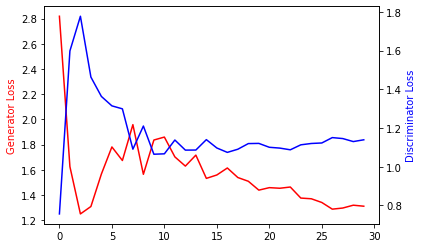

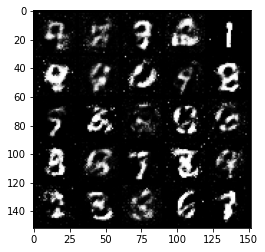

In [11]:
gen_loss, dis_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, gen_criterion, dis_criterion, batch_size, z_dim, epochs)